In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [30]:
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
pip install mediapipe

In [32]:
import seaborn as sns
import cv2
import pandas as pd
from datetime import datetime
import mediapipe as mp
from tqdm import tqdm
from tqdm import tqdm

In [33]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Define constants
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30
SEQUENCE_LENGTH = 20  # Number of frames in each sequence
NUM_FEATURES = 5  # EAR left, EAR right, blink duration, face angle, etc.

In [35]:
def create_directories():
    base_dir = "/content/drive/My Drive/Eye fatigue/train"
    os.makedirs(base_dir, exist_ok=True)
    for subset in ['train', 'validation', 'test']:
        for label in ['alert', 'mild_fatigue', 'severe_fatigue']:
            path = os.path.join(base_dir, subset, label)
            os.makedirs(path, exist_ok=True)
    return base_dir

In [36]:
# Extract facial landmarks and calculate EAR
def setup_face_mesh():
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5)
    return face_mesh

In [37]:

def calculate_ear(landmarks, left_eye_indices, right_eye_indices):
    """Calculate Eye Aspect Ratio for left and right eyes"""
    def aspect_ratio(eye_landmarks):
        # Vertical eye landmarks (top to bottom)
        v1 = landmarks[eye_landmarks[1]]
        v2 = landmarks[eye_landmarks[5]]
        # Horizontal eye landmarks (left to right)
        h1 = landmarks[eye_landmarks[0]]
        h2 = landmarks[eye_landmarks[3]]

        # Calculate EAR
        return np.linalg.norm(v1 - v2) / (2 * np.linalg.norm(h1 - h2))

    left_eye = np.array([[landmarks[i].x, landmarks[i].y] for i in left_eye_indices])
    right_eye = np.array([[landmarks[i].x, landmarks[i].y] for i in right_eye_indices])

    left_ear = aspect_ratio(left_eye)
    right_ear = aspect_ratio(right_eye)

    return left_ear, right_ear


In [38]:
# Define eye indices for MediaPipe face landmarks
# MediaPipe provides 468 face landmarks
LEFT_EYE_INDICES = [362, 385, 387, 263, 373, 380]
RIGHT_EYE_INDICES = [33, 160, 158, 133, 153, 144]

In [39]:

def extract_features_from_video(video_path, face_mesh, sequence_length=SEQUENCE_LENGTH):
    """Extract features from video for sequence-based models"""
    cap = cv2.VideoCapture(video_path)
    features = []

    # Variables to track blink metrics
    blink_count = 0
    blink_start_time = None
    is_blinking = False
    blink_durations = []
    current_time = 0
    fps = cap.get(cv2.CAP_PROP_FPS)

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Increment time counter
        current_time += 1/fps

        # Convert to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w, _ = frame.shape

        # Process frame with MediaPipe
        results = face_mesh.process(rgb_frame)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            landmarks_array = np.array([(lm.x, lm.y, lm.z) for lm in landmarks])

            # Calculate EAR
            left_ear, right_ear = calculate_ear(landmarks, LEFT_EYE_INDICES, RIGHT_EYE_INDICES)
            avg_ear = (left_ear + right_ear) / 2

            # Track blink state
            if avg_ear < 0.2 and not is_blinking:
                is_blinking = True
                blink_start_time = current_time
                blink_count += 1
            elif avg_ear >= 0.2 and is_blinking:
                is_blinking = False
                blink_duration = current_time - blink_start_time
                blink_durations.append(blink_duration)

            # Calculate blink rate (blinks per minute)
            blink_rate = blink_count / (current_time / 60) if current_time > 0 else 0

            # Calculate average blink duration
            avg_blink_duration = np.mean(blink_durations) if blink_durations else 0

            # Calculate head pose estimation (simplistic)
            # Using the face center and orientation as a proxy
            face_center = landmarks_array[0]  # Nose bridge point

            # Store features
            feature_vector = [
                left_ear,
                right_ear,
                blink_rate,
                avg_blink_duration,
                face_center[2]  # Z coordinate as depth proxy
            ]

            features.append(feature_vector)

    cap.release()

    # Ensure we have the right sequence length
    if len(features) < sequence_length:
        # Pad with zeros if sequence is too short
        padding = [np.zeros(NUM_FEATURES) for _ in range(sequence_length - len(features))]
        features.extend(padding)
    elif len(features) > sequence_length:
        # Sample evenly from the sequence if it's too long
        indices = np.linspace(0, len(features)-1, sequence_length, dtype=int)
        features = [features[i] for i in indices]

    return np.array(features)

In [40]:
# Function to process a folder of videos into a dataset of sequences
def create_sequence_dataset(dataset_dir, face_mesh):
    X = []
    y = []

    # Define label encoding
    class_mapping = {
        'alert': 0,
        'mild_fatigue': 1,
        'severe_fatigue': 2
    }

    # Process videos in each class folder
    for class_name, class_id in class_mapping.items():
        class_dir = os.path.join(dataset_dir, class_name)
        for video_file in tqdm(os.listdir(class_dir)):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(class_dir, video_file)

                # Extract features from video
                features = extract_features_from_video(video_path, face_mesh)

                # Append to dataset
                X.append(features)
                y.append(class_id)

    return np.array(X), np.array(y)

In [41]:
# Create CNN+LSTM model for processing both spatial and temporal features
def create_hybrid_model(sequence_length, num_features):
    """Create a hybrid CNN+LSTM model for eye fatigue detection"""
    model = Sequential([
        # LSTM layers for sequence processing
        LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),

        # Fully connected layers
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes: alert, mild_fatigue, severe_fatigue
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [42]:
# Create a CNN-LSTM model for image sequences
def create_cnn_lstm_model(sequence_length, img_height, img_width):
    """Create a CNN+LSTM model for processing sequences of images"""

    # CNN model for feature extraction
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(64, activation='relu')
    ])

    # Create a TimeDistributed wrapper for the CNN
    model = Sequential([
        TimeDistributed(cnn_model, input_shape=(sequence_length, img_height, img_width, 3)),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: alert, mild_fatigue, severe_fatigue
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [43]:
# For situations where you don't have a video dataset yet
# This function generates synthetic data for testing the model
def generate_synthetic_data(num_samples=100, sequence_length=SEQUENCE_LENGTH, num_classes=3):
    """Generate synthetic data for testing the model architecture"""
    X = np.zeros((num_samples, sequence_length, NUM_FEATURES))
    y = np.zeros(num_samples)

    for i in range(num_samples):
        # Randomly assign a class label
        label = np.random.randint(0, num_classes)
        y[i] = label

        # Generate synthetic features based on the label
        for j in range(sequence_length):
            if label == 0:  # Alert
                # High EAR, low blink rate, low blink duration
                X[i, j, 0] = np.random.normal(0.3, 0.05)  # Left EAR
                X[i, j, 1] = np.random.normal(0.3, 0.05)  # Right EAR
                X[i, j, 2] = np.random.normal(10, 2)      # Blink rate
                X[i, j, 3] = np.random.normal(0.15, 0.02) # Blink duration
                X[i, j, 4] = np.random.normal(0, 0.1)     # Face position

            elif label == 1:  # Mild fatigue
                # Medium EAR, medium blink rate, medium blink duration
                X[i, j, 0] = np.random.normal(0.25, 0.05)  # Left EAR
                X[i, j, 1] = np.random.normal(0.25, 0.05)  # Right EAR
                X[i, j, 2] = np.random.normal(15, 3)       # Blink rate
                X[i, j, 3] = np.random.normal(0.25, 0.05)  # Blink duration
                X[i, j, 4] = np.random.normal(0.2, 0.1)    # Face position

            else:  # Severe fatigue
                # Low EAR, high blink rate, high blink duration
                X[i, j, 0] = np.random.normal(0.2, 0.05)   # Left EAR
                X[i, j, 1] = np.random.normal(0.2, 0.05)   # Right EAR
                X[i, j, 2] = np.random.normal(25, 5)       # Blink rate
                X[i, j, 3] = np.random.normal(0.35, 0.05)  # Blink duration
                X[i, j, 4] = np.random.normal(0.4, 0.2)    # Face position

            # Add some temporal pattern - gradually change values over time
            X[i, j, 0] -= j * 0.001 * (label + 1)  # EAR decreases more with fatigue
            X[i, j, 1] -= j * 0.001 * (label + 1)  # EAR decreases more with fatigue

    return X, y

In [44]:
# Functions for training and evaluation
def train_model(model, X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """Train the model and return the training history"""

    # Define callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001
    )

    model_checkpoint = ModelCheckpoint(
        'best_eye_fatigue_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr, model_checkpoint]
    )

    return history

In [45]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model and print classification report"""
    # Predict test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes,
                               target_names=['Alert', 'Mild Fatigue', 'Severe Fatigue']))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Alert', 'Mild Fatigue', 'Severe Fatigue'],
                yticklabels=['Alert', 'Mild Fatigue', 'Severe Fatigue'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print test accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

    return y_pred_classes

In [46]:
def plot_training_history(history):
    """Plot the training and validation accuracy/loss"""
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.tight_layout()
    plt.show()

In [47]:
def plot_sample_sequence(X, y, sample_idx=0):
    """Plot features from a sample sequence"""
    feature_names = ['Left EAR', 'Right EAR', 'Blink Rate', 'Blink Duration', 'Face Position']
    class_names = ['Alert', 'Mild Fatigue', 'Severe Fatigue']

    sequence = X[sample_idx]
    class_label = y[sample_idx]

    plt.figure(figsize=(14, 10))
    for i in range(NUM_FEATURES):
        plt.subplot(NUM_FEATURES, 1, i+1)
        plt.plot(sequence[:, i])
        plt.title(f'{feature_names[i]} over time - {class_names[int(class_label)]}')
        plt.xlabel('Time')
        plt.ylabel(feature_names[i])

    plt.tight_layout()
    plt.show()

In [48]:
# Main execution
def main():
    print("Eye Fatigue Detection with RNN - Starting...")

    # Generate synthetic data for model development
    print("\nGenerating synthetic data for model testing...")
    X_synth, y_synth = generate_synthetic_data(num_samples=500)

    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_synth, y_synth, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print(f"Train set: {X_train.shape}, {y_train.shape}")
    print(f"Validation set: {X_val.shape}, {y_val.shape}")
    print(f"Test set: {X_test.shape}, {y_test.shape}")

    # Plot a sample sequence
    print("\nPlotting a sample sequence...")
    plot_sample_sequence(X_train, y_train, sample_idx=0)

    # Create and compile the model
    print("\nCreating the LSTM model...")
    model = create_hybrid_model(SEQUENCE_LENGTH, NUM_FEATURES)
    model.summary()

    # Train the model
    print("\nTraining the model...")
    history = train_model(model, X_train, y_train, X_val, y_val)

    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(history)

    # Evaluate the model
    print("\nEvaluating the model...")
    y_pred_classes = evaluate_model(model, X_test, y_test)

    # Save the model
    model_path = "/content/eye_fatigue_rnn_model.h5"
    model.save(model_path)
    print(f"\nModel saved at {model_path}")

    # Optional: Save model to Google Drive
    drive_model_path = "/content/drive/MyDrive/eye_fatigue_rnn_model.h5"
    model.save(drive_model_path)
    print(f"Model also saved to Google Drive at {drive_model_path}")

    # Implementation example for real-time prediction
    print("\nExample code for real-time prediction:")
    print("""
    def predict_fatigue_level(feature_sequence):
        # Reshape to match model input shape
        feature_sequence = np.array([feature_sequence])

        # Make prediction
        prediction = model.predict(feature_sequence)
        fatigue_level = np.argmax(prediction[0])
        confidence = prediction[0][fatigue_level]

        # Return result
        result = {
            'fatigue_level': int(fatigue_level),
            'fatigue_state': ['Alert', 'Mild Fatigue', 'Severe Fatigue'][fatigue_level],
            'confidence': float(confidence)
        }
        return result
    """)

    print("\nEye Fatigue Detection with RNN - Completed!")

Eye Fatigue Detection with RNN - Starting...

Generating synthetic data for model testing...
Train set: (350, 20, 5), (350,)
Validation set: (75, 20, 5), (75,)
Test set: (75, 20, 5), (75,)

Plotting a sample sequence...


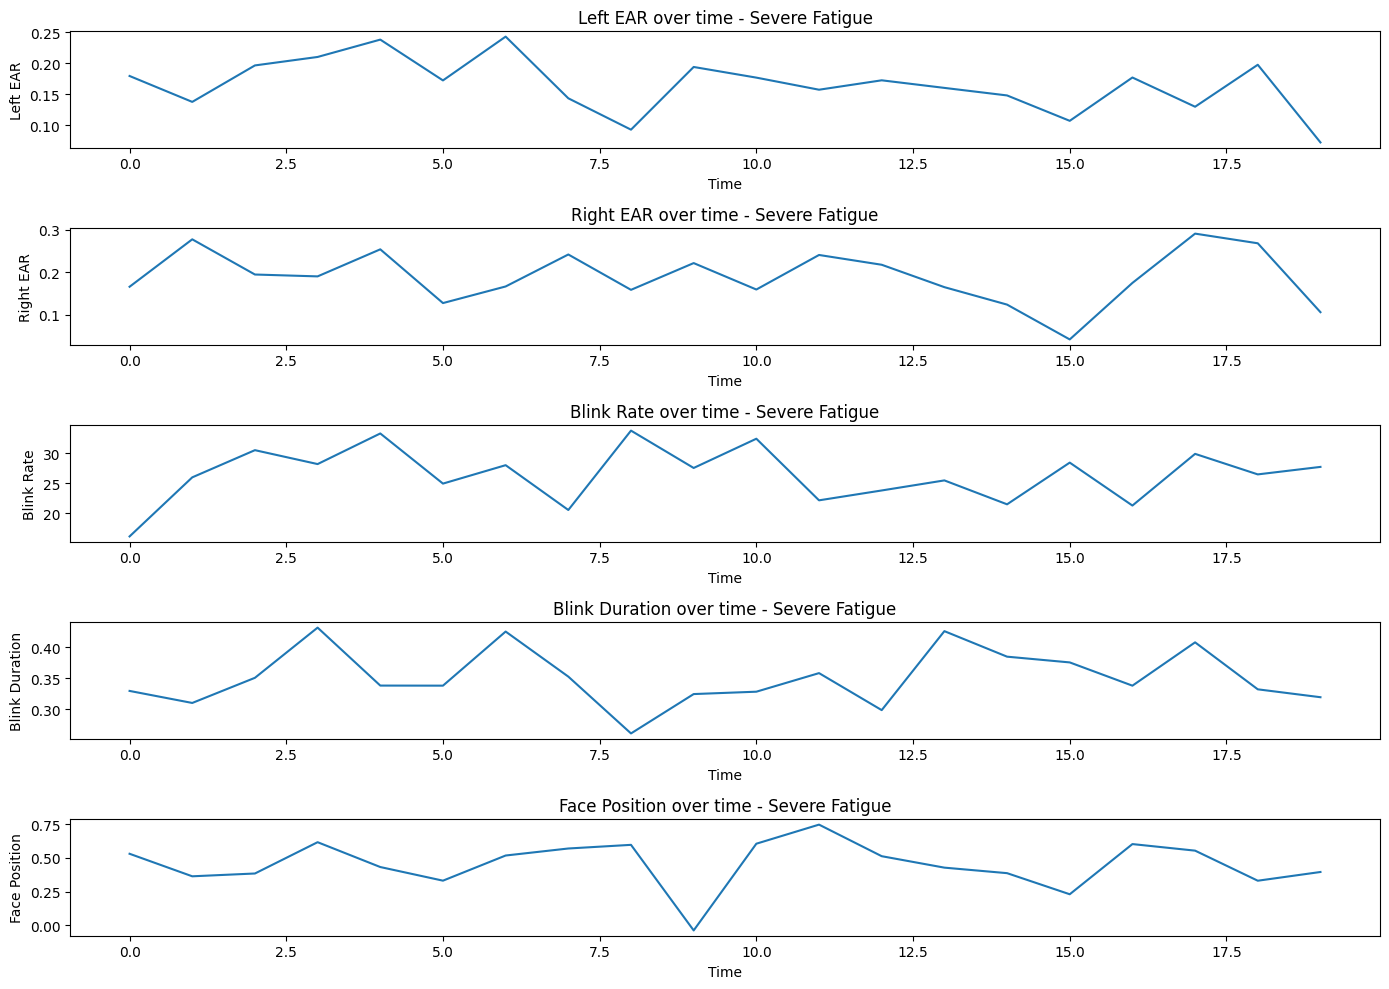


Creating the LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 20, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,979 (121.01 KB)

 Trainable params: 30,947 (120.89 KB)

 Non-trainable params: 32 (128.00 B)


Training the model...
Epoch 1/30
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3471 - loss: 1.3533

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.3597 - loss: 1.3349 - val_accuracy: 0.6400 - val_loss: 0.9982 - learning_rate: 0.0010
Epoch 2/30
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6390 - loss: 0.8689

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6410 - loss: 0.8619 - val_accuracy: 0.9867 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7600 - loss: 0.5881 - val_accuracy: 0.9867 - val_loss: 0.6504 - learning_rate: 0.0010
Epoch 4/30
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8649 - loss: 0.3984

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8655 - loss: 0.3942 - val_accuracy: 1.0000 - val_loss: 0.4995 - learning_rate: 0.0010
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9352 - loss: 0.2578 - val_accuracy: 1.0000 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9539 - loss: 0.2497 - val_accuracy: 1.0000 - val_loss: 0.3041 - learning_rate: 0.0010
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9846 - loss: 0.1747 - val_accuracy: 1.0000 - val_loss: 0.2437 - learning_rate: 0.0010
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9929 - loss: 0.1479 - val_accuracy: 1.0000 - val_loss: 0.1957 - learning_rate: 0.0010
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9906 - loss: 0.1585 - val_accuracy: 1.0000 - val_loss: 0.1507 - learning_rate: 0.0010
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9647 - loss: 0.1440 - val_accuracy: 1.0

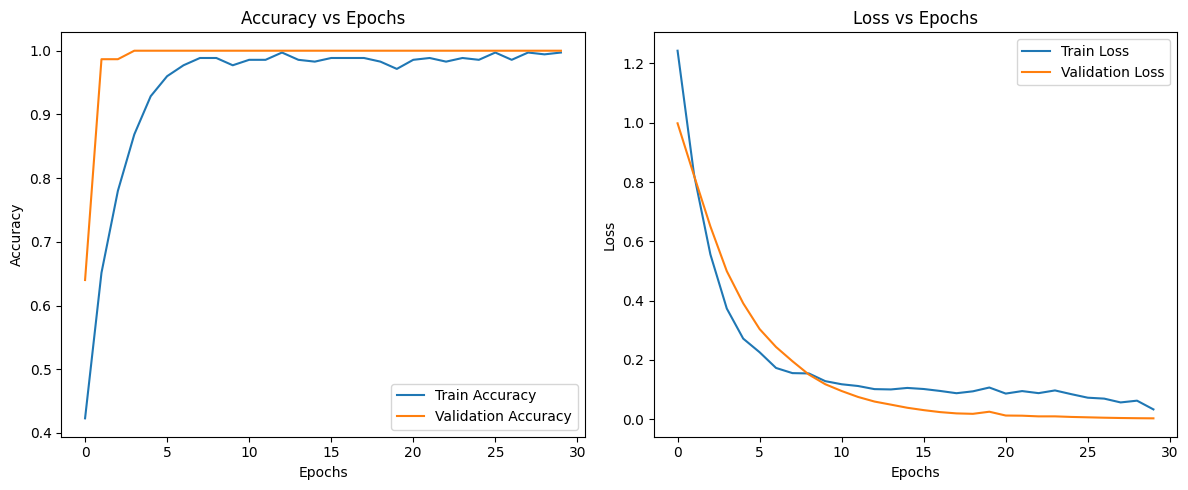


Evaluating the model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step

Classification Report:
                precision    recall  f1-score   support

         Alert       1.00      1.00      1.00        26
  Mild Fatigue       1.00      1.00      1.00        29
Severe Fatigue       1.00      1.00      1.00        20

      accuracy                           1.00        75
     macro avg       1.00      1.00      1.00        75
  weighted avg       1.00      1.00      1.00        75



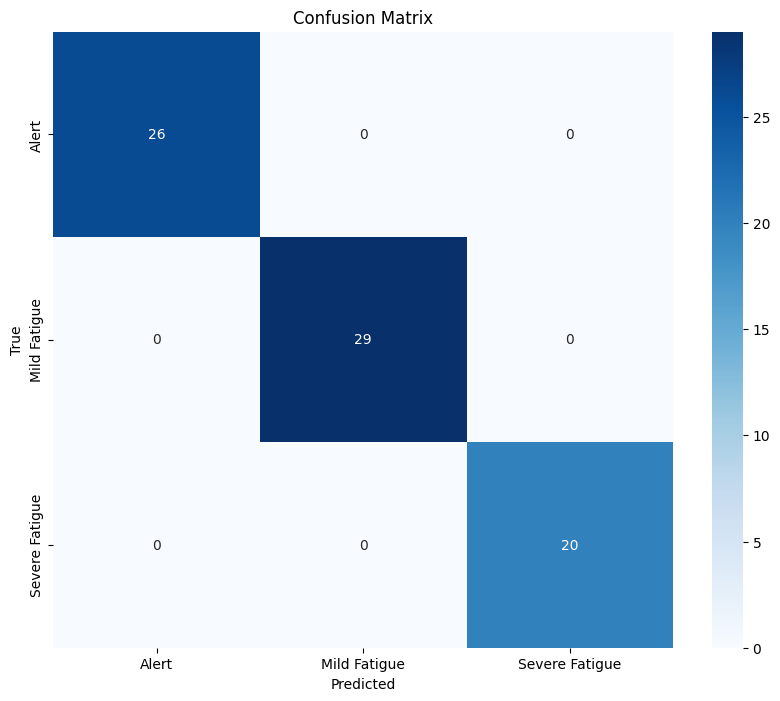

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0030



Test Accuracy: 100.00%

Model saved at /content/eye_fatigue_rnn_model.h5
Model also saved to Google Drive at /content/drive/MyDrive/eye_fatigue_rnn_model.h5

Example code for real-time prediction:

    def predict_fatigue_level(feature_sequence):
        # Reshape to match model input shape
        feature_sequence = np.array([feature_sequence])
        
        # Make prediction
        prediction = model.predict(feature_sequence)
        fatigue_level = np.argmax(prediction[0])
        confidence = prediction[0][fatigue_level]
        
        # Return result
        result = {
            'fatigue_level': int(fatigue_level),
            'fatigue_state': ['Alert', 'Mild Fatigue', 'Severe Fatigue'][fatigue_level],
            'confidence': float(confidence)
        }
        return result
    

Eye Fatigue Detection with RNN - Completed!


In [49]:
# Execute main function
if __name__ == "__main__":
    main()